In [1]:
import re
import gc
import os
import time
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt

from IPython.display import clear_output

import keras
from keras import optimizers
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Input, Dropout, Flatten, Activation, Conv1D, LSTM
from keras.layers.advanced_activations import PReLU
from keras.initializers import Constant
from keras.initializers import he_normal, he_uniform
from keras.models import Model
from keras.optimizers import Adam, Nadam
from keras.callbacks import TensorBoard
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler

from glob import glob

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.layers import Dense, SimpleRNN, LSTM, Bidirectional, TimeDistributed, Conv1D, ZeroPadding1D, GRU
from keras.layers import Lambda, Input, Dropout, Masking, BatchNormalization, Activation
from keras.models import Model

Using TensorFlow backend.


In [2]:
# seems to reduce the chance of gpu errors, also doesn't blindly allocate all vram 

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [3]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def list_wavs_fname(dirpath, ext='wav'):
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+\\(\w+)\\\w+\.wav$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+\\(\w+\.wav)$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [4]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.\\data'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'input', 'train', 'audio')
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [5]:
labels, fnames = list_wavs_fname(train_data_path)
np.random.seed(0)

new_sample_rate = 16000
y = []
x = []
t0 = datetime.datetime.now()
i = 1

for label, fname in zip(labels, fnames):
    if i%100 == 0:
        delta = datetime.datetime.now() - t0
        clear_output(wait=True)
        print('%.2f%% %.1f seconds left' % (i/647.27, delta.total_seconds()*(64727/i-1)))
    i+=1
    if label not in legal_labels and label != '_background_noise_' and np.random.randint(10) > 0:
        continue
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y.append(label)
        x.append(specgram)
x = np.array(x)
y = label_transform(y)
label_index = y.columns.values
y = y.values
y = np.array(y)
x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
del x, y
gc.collect()

99.96% 0.1 seconds left


C:\Users\01124585\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.


14

In [16]:
x_mean

-3.9128385

In [6]:
np.random.seed(0)
def little_boy():
    i = Input(shape=(99, 161))
    x = Dropout(0.2)(i)
    x = Conv1D(filters=256, kernel_size=19, strides=8, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(x)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
        
    x = LSTM(256, unroll=True,
             dropout=0.4, recurrent_dropout=0.5, 
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5))(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform())(x)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    o = Dense(12, activation='softmax')(x)
    
    return Model(inputs=i, outputs=o)

model = little_boy()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99, 161)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 99, 161)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 256)           783360    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 11, 256)           2816      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 256)           1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

In [7]:
opt = Nadam(lr=1e-3, epsilon=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

def step_scheduler(epoch, lr):
    return 2e-3 - 1e-5*epoch

history = model.fit(x_train, y_train,
                    workers=2,
                    batch_size=512, epochs=200,
                    validation_data=(x_test, y_test),
                    verbose=2,
                    callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

Train on 20655 samples, validate on 5164 samples
Epoch 1/200
 - 6s - loss: 7.0163 - accuracy: 0.2314 - val_loss: 5.2072 - val_accuracy: 0.2593
Epoch 2/200
 - 3s - loss: 3.9925 - accuracy: 0.4415 - val_loss: 3.3387 - val_accuracy: 0.4105
Epoch 3/200
 - 3s - loss: 2.4243 - accuracy: 0.6050 - val_loss: 2.1275 - val_accuracy: 0.6679
Epoch 4/200
 - 3s - loss: 1.6736 - accuracy: 0.6909 - val_loss: 1.6370 - val_accuracy: 0.7151
Epoch 5/200
 - 3s - loss: 1.2730 - accuracy: 0.7513 - val_loss: 1.4132 - val_accuracy: 0.7527
Epoch 6/200
 - 3s - loss: 1.0972 - accuracy: 0.7764 - val_loss: 1.0723 - val_accuracy: 0.8447
Epoch 7/200
 - 3s - loss: 0.9605 - accuracy: 0.8068 - val_loss: 1.1112 - val_accuracy: 0.7622
Epoch 8/200
 - 3s - loss: 0.8873 - accuracy: 0.8168 - val_loss: 0.8424 - val_accuracy: 0.8658
Epoch 9/200
 - 3s - loss: 0.8342 - accuracy: 0.8297 - val_loss: 0.7423 - val_accuracy: 0.8797
Epoch 10/200
 - 3s - loss: 0.7892 - accuracy: 0.8376 - val_loss: 0.7821 - val_accuracy: 0.8408
Epoch 11/2

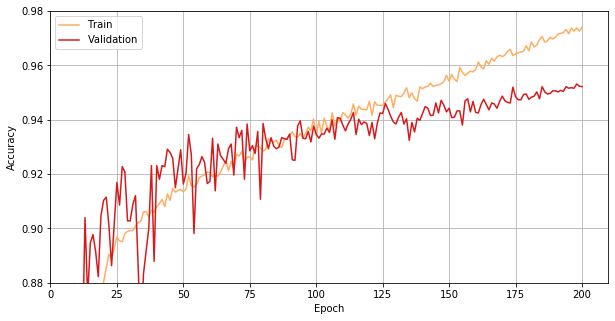

In [8]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

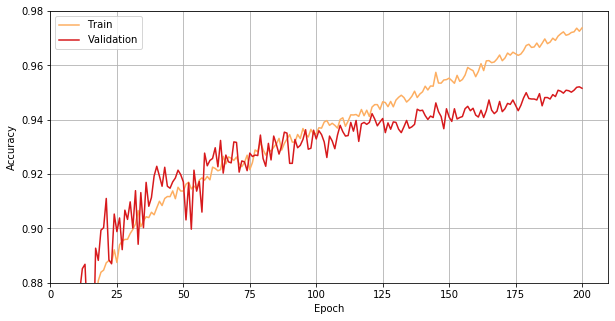

In [20]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.88, .98)
plt.xlim(0)
plt.grid()
plt.show()

In [75]:
def big_boy():
    input_data = Input(shape=(99, 161))

    x = Conv1D(filters=256, kernel_size=11, strides=4, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(input_data)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
        
    x = LSTM(128, return_sequences=True,
             dropout=0.2, recurrent_dropout=0.3,
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5))(x)
    x = LSTM(128,
             dropout=0.2, recurrent_dropout=0.3, 
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5))(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform())(x)
    x = PReLU(alpha_initializer=Constant(value=0.25))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    y_pred = Dense(units=12, activation='softmax')(x)
    
    return Model(inputs=input_data, outputs=y_pred)

model = big_boy()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 99, 161)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 23, 256)           453632    
_________________________________________________________________
activation_1 (Activation)    (None, 23, 256)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 23, 256)           1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 23, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 23, 128)           197120    
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               1315

In [76]:
from keras.optimizers import Adam

opt = Adam(lr=1e-3, epsilon=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

def step_scheduler(epoch, lr):
    return 1e-3 - 2e-5*epoch

history = model.fit(x_train, y_train,
                    batch_size=128, epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

Train on 22299 samples, validate on 5575 samples
Epoch 1/50
15360/22299 [===================>..........] - ETA: 3s - loss: 1.9080 - accuracy: 0.3200

KeyboardInterrupt: 

In [41]:
# big boy
Epoch 40/50
22392/22392 [==============================] - 12s 551us/sample - loss: 0.0936 - accuracy: 0.9691 - val_loss: 0.2047 - val_accuracy: 0.9489
Epoch 41/50
22392/22392 [==============================] - 12s 549us/sample - loss: 0.0863 - accuracy: 0.9713 - val_loss: 0.2121 - val_accuracy: 0.9471
Epoch 42/50
22392/22392 [==============================] - 12s 545us/sample - loss: 0.0867 - accuracy: 0.9717 - val_loss: 0.2081 - val_accuracy: 0.9496
Epoch 43/50
22392/22392 [==============================] - 12s 547us/sample - loss: 0.0805 - accuracy: 0.9727 - val_loss: 0.2127 - val_accuracy: 0.9496
Epoch 44/50
22392/22392 [==============================] - 12s 550us/sample - loss: 0.0747 - accuracy: 0.9753 - val_loss: 0.2151 - val_accuracy: 0.9478
Epoch 45/50
22392/22392 [==============================] - 12s 544us/sample - loss: 0.0779 - accuracy: 0.9740 - val_loss: 0.2125 - val_accuracy: 0.9505
Epoch 46/50
22392/22392 [==============================] - 12s 548us/sample - loss: 0.0735 - accuracy: 0.9758 - val_loss: 0.2147 - val_accuracy: 0.9512
Epoch 47/50
22392/22392 [==============================] - 12s 545us/sample - loss: 0.0742 - accuracy: 0.9737 - val_loss: 0.2159 - val_accuracy: 0.9514
Epoch 48/50
22392/22392 [==============================] - 12s 548us/sample - loss: 0.0689 - accuracy: 0.9773 - val_loss: 0.2066 - val_accuracy: 0.9512
Epoch 49/50
22392/22392 [==============================] - 12s 547us/sample - loss: 0.0679 - accuracy: 0.9764 - val_loss: 0.2133 - val_accuracy: 0.9518
Epoch 50/50
22392/22392 [==============================] - 12s 545us/sample - loss: 0.0676 - accuracy: 0.9770 - val_loss: 0.2113 - val_accuracy: 0.9516

SyntaxError: invalid syntax (<ipython-input-41-443c2918ecfa>, line 2)

In [9]:
import collections
collections.Counter(label_index[np.argmax(y_train, axis=1)])

Counter({'on': 1894,
         'down': 1878,
         'left': 1904,
         'no': 1888,
         'up': 1893,
         'off': 1879,
         'silence': 93,
         'unknown': 1651,
         'stop': 1865,
         'go': 1911,
         'yes': 1918,
         'right': 1881})

In [10]:
def test_data_generator(batch):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            yield fnames, (np.array(imgs) - x_mean) / x_std
    yield fnames, (np.array(imgs) - x_mean) / x_std
    raise StopIteration()

In [11]:
gc.collect()

index = []
results = []
t0 = datetime.datetime.now()
i = 1
b = 128

for fnames, imgs in test_data_generator(b):
    predicts = model.predict(imgs)
    predicts = np.argmax(predicts, axis=1)
    predicts = [label_index[p] for p in predicts]
    index.extend(fnames)
    results.extend(predicts)
    delta = datetime.datetime.now() - t0
    clear_output(wait=True)
    print('%.2f%% %.1f seconds left' % (b*i/1585.38, delta.total_seconds()*(158538/b/i-1)))
    i+=1

100.03% -0.3 seconds left


RuntimeError: generator raised StopIteration

In [12]:
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results
df.to_csv(os.path.join(out_path, 'submission.csv'), index=False)

In [13]:
df['label'].value_counts()

unknown    60208
on         17915
go         10349
right       9910
no          8976
up          8186
left        7721
down        7651
silence     7641
off         7002
stop        6620
yes         6359
Name: label, dtype: int64